In [1]:
# import hbsir

# The following code is written to import hbsir library from this
# repository without installation. Usually, you can import the library
# by writing "import hbsir"

try:
    import hbsir

except ModuleNotFoundError:
    import sys
    from pathlib import Path

    for parent in Path().absolute().parents:
        if len(list(parent.glob("hbsir"))) > 0:
            hbsir_path = parent
            break
    else:
        raise FileNotFoundError

    sys.path.append(str(hbsir_path))

    import hbsir

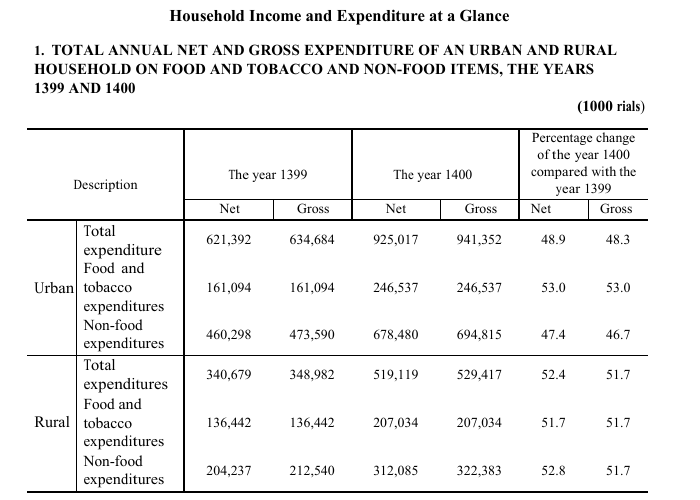

In [2]:
from pdf2image import pdf2image
try:
    with open("summery-results.pdf", mode="rb") as pdf_file:
        pdf_content = pdf_file.read()
except FileNotFoundError:
    import requests
    url = r"https://www.amar.org.ir/LinkClick.aspx?fileticket=Sxo6JC4OCi8%3d&portalid=1"
    report_file = requests.get(url)
    pdf_content = report_file.content
    with open("summery-results.pdf", mode="wb") as pdf_file:
        pdf_file.write(pdf_content)
report_pages = pdf2image.convert_from_bytes(pdf_content, dpi=100)
expenditure_summery_table = report_pages[3].crop((50, 60, 750, 560))
expenditure_summery_table

In [3]:
import pandas as pd

In [4]:
def prepare_expenditure_table(year):
    df = hbsir.read_hbs("Expenditures", year)
    df = hbsir.add_attribute(df, attribute="Urban-Rural")
    df = hbsir.add_classification(df, "Food-NonFood")
    df["Expenditure"] = df["Expenditure"] * 360 / df["Duration"]
    df["Secondhand_Sale"] = df["Secondhand_Sale"] * 360 / df["Duration"]
    df["Net"] = df.fillna(0).eval("Expenditure - Secondhand_Sale")
    df["Gross"] = df["Expenditure"]
    return df

def prepare_household_info_table(year):
    df = hbsir.load_table("household_information", year)
    df = hbsir.add_attribute(df, attribute="Urban-Rural")
    df = df.set_index("ID")
    return df

def calc_hh_agg(df, urban_rural):
    df = df.copy()
    filt = df["Urban-Rural"] == urban_rural
    df = df.loc[filt].groupby(["ID", "Food-NonFood"])[["Net", "Gross"]].sum()
    df = df.unstack([1])
    return df

def calc_wghtd_avrg(df, hh_info, urban_rural):
    filt = hh_info["Urban-Rural"] == urban_rural
    weights = hh_info.loc[filt, "Weight"]
    wghtd_avrg = df.apply(lambda column: (column * weights).sum() / weights.sum()) / 1000
    return wghtd_avrg

def add_totals(df):
    totals = df.groupby(level=[0, 1]).sum()
    totals = pd.concat({"Total": totals}, names=["Food-NonFood", "Urban-Rural", "Net-Gross"])
    totals.index = totals.index.reorder_levels(["Urban-Rural", "Net-Gross", "Food-NonFood"])
    return pd.concat([df, totals])

def create_year_table(year):
    expenditures = prepare_expenditure_table(year)
    hh_info = prepare_household_info_table(year)
    
    agg_tables = []
    for ur_ru in ["Urban", "Rural"]:
        df = calc_hh_agg(expenditures, ur_ru)
        df = calc_wghtd_avrg(df, hh_info, ur_ru)
        df.index.rename(["Net-Gross", "Food-NonFood"], inplace=True)
        agg_tables.append(df)
    year_table = pd.concat(agg_tables, keys=["Urban", "Rural"], names=["Urban-Rural"])
    year_table = add_totals(year_table)
    year_table = year_table.sort_index()
    year_table = year_table.unstack(1)
    return year_table

def sort_items(series):
    index = {
        "Urban":    1,
        "Rural":    2,
        "Total":    11,
        "Food":     12,
        "Non-Food": 13,
        1399:       21,
        1400:       22,
        "Net":      31,
        "Gross":    32,
    }
    series = series.map(index)
    return series

In [5]:
exp_1399 = create_year_table(1399)
exp_1400 = create_year_table(1400)
final_table = pd.concat({1399: exp_1399, 1400: exp_1400}, axis="columns").astype(int)
final_table = final_table.sort_index(axis="index", key=sort_items)
final_table = final_table.sort_index(axis="columns", key=sort_items)
final_table.style.format("{:,.0f}")

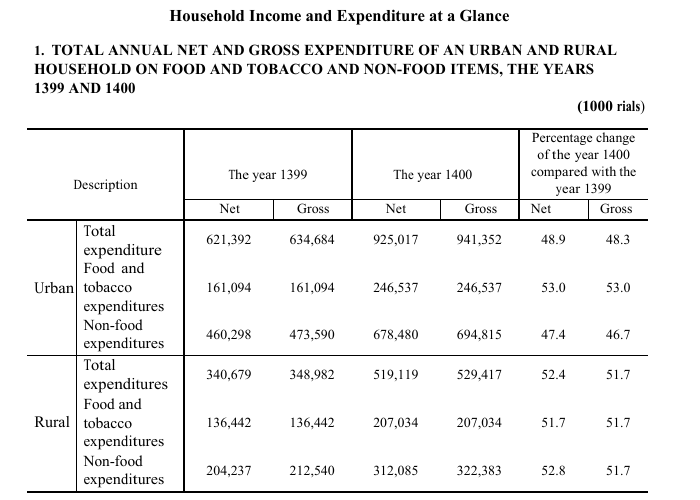

In [6]:
expenditure_summery_table